# Financial time series prediction with LSTM and GRU
In this lab, we will start working with the time series of loan delinquency status, in order to predict them.

As always, let's first import the packages we will use and the data.

In [1]:
# Install necessasary packages, if not done before
!pip install torchview
!pip install livelossplot

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/18ERhjQQg-PB6a5wEyUTNecJv8zkz0GkK/view?usp=sharing'
!gdown --fuzzy 'https://drive.google.com/file/d/1B2R1nCGIJ4TURvh7RL-aoLHAe8oP-uxO/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=18ERhjQQg-PB6a5wEyUTNecJv8zkz0GkK
To: /content/Time_Series_Lab_sampled.csv
100% 98.2M/98.2M [00:01<00:00, 77.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B2R1nCGIJ4TURvh7RL-aoLHAe8oP-uxO
To: /content/TIme_Series_Lab_Origin_sampled.csv
100% 2.30M/2.30M [00:00<00:00, 25.0MB/s]


In [3]:
import numpy as np
import PIL
import os
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# For validation
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from torchview import draw_graph
import graphviz
from livelossplot import PlotLosses
graphviz.set_jupyter_format('png')
%matplotlib inline

# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler

Now, we load the dataset, which originates from Freddie Mac. It contains monthly loan status updates spanning from November 2021 to June 2024.

In [4]:
# Read the data
df = pd.read_csv('Time_Series_Lab_sampled.csv')
df

<ipython-input-4-421512331>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Time_Series_Lab_sampled.csv')


,LOAN_NUMBER,REPORTING_PERIOD,CURRENT_ACTUAL_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB
0,F21Q40000008,202111,68000.00,0,0,360,3.375,0.0,82,68000.00
1,F21Q40000008,202112,68000.00,0,1,359,3.375,0.0,82,68000.00
2,F21Q40000008,202201,68000.00,0,2,358,3.375,0.0,79,68000.00
3,F21Q40000008,202202,68000.00,0,3,357,3.375,0.0,73,68000.00
4,F21Q40000008,202203,68000.00,0,4,356,3.375,0.0,69,68000.00
...,...,...,...,...,...,...,...,...,...,...
1599995,F21Q40674751,202402,356572.31,0,27,333,3.000,0.0,63,356572.31
1599996,F21Q40674751,202403,355884.83,0,28,332,3.000,0.0,61,355884.83
1599997,F21Q40674751,202404,355195.63,0,29,331,3.000,0.0,58,355195.63
1599998,F21Q40674751,202405,354504.71,0,30,330,3.000,0.0,57,354504.71


We assign a value of 1 to loans that were delinquent at least once in the last three months (April to June 2024). Our goal is to predict whether a loan will become delinquent in the next quarter.

In [5]:
# Convert REPORTING_PERIOD to datetime for sorting
df["REPORTING_PERIOD"] = pd.to_datetime(df["REPORTING_PERIOD"], format='%Y%m')

df["CURRENT_LOAN_DELINQUENCY_STATUS"] = pd.to_numeric(df["CURRENT_LOAN_DELINQUENCY_STATUS"], errors='coerce').fillna(1)

# Sort data by Loan Number and Reporting Period (chronological order)
df = df.sort_values(by=["LOAN_NUMBER", "REPORTING_PERIOD"])


# Identify loans that were delinquent at least once in the period 2024-04 to 2024-06
df["CURRENT_LOAN_DELINQUENCY_STATUS"] = (df["CURRENT_LOAN_DELINQUENCY_STATUS"] > 0).astype(int)
mask = (df["REPORTING_PERIOD"] >= "2024-04-01") & (df["REPORTING_PERIOD"] <= "2024-06-30")
df["target"] = df.groupby("LOAN_NUMBER")["CURRENT_LOAN_DELINQUENCY_STATUS"].transform(lambda x: x[mask].max()).astype(int)


# Remove the last three months (April 2024 - June 2024)
df = df[~df["REPORTING_PERIOD"].between(pd.Timestamp("2024-03-31"), pd.Timestamp("2024-06-02"))]
df

,LOAN_NUMBER,REPORTING_PERIOD,CURRENT_ACTUAL_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,target
0,F21Q40000008,2021-11-01,68000.00,0,0,360,3.375,0.0,82,68000.00,0
1,F21Q40000008,2021-12-01,68000.00,0,1,359,3.375,0.0,82,68000.00,0
2,F21Q40000008,2022-01-01,68000.00,0,2,358,3.375,0.0,79,68000.00,0
3,F21Q40000008,2022-02-01,68000.00,0,3,357,3.375,0.0,73,68000.00,0
4,F21Q40000008,2022-03-01,68000.00,0,4,356,3.375,0.0,69,68000.00,0
...,...,...,...,...,...,...,...,...,...,...,...
1599992,F21Q40674751,2023-11-01,358624.47,0,24,336,3.000,0.0,59,358624.47,0
1599993,F21Q40674751,2023-12-01,357942.12,0,25,335,3.000,0.0,64,357942.12,0
1599994,F21Q40674751,2024-01-01,357258.07,0,26,334,3.000,0.0,64,357258.07,0
1599995,F21Q40674751,2024-02-01,356572.31,0,27,333,3.000,0.0,63,356572.31,0


## Long-Short Term Memory (LSTM) Networks
First, we will train an LSTM. The LSTM is a fairly complex model, so VRAM will be a signficant constraint. Let's first set up the train and test dataset. We will normalize the data and One Hot Encode the labels using sklearn's OneHotEncode function. We will also set the class weights as we have done before.

In [6]:
num_cols = [
    "CURRENT_ACTUAL_UPB",
    "LOAN_AGE",
    "REMAINING_MONTHS",
    "CURRENT_INTEREST_RATE",
    "CURRENT_NON_INTEREST_BEARING_UPB",
    "ESTIMATED_LOAN_TO_VALUE",
    "INTEREST_BEARING_UPB",
    "CURRENT_LOAN_DELINQUENCY_STATUS"
]

# Group by loan number for sequence creation
grouped = df.groupby("LOAN_NUMBER")

# Store sequences and targets
X_dict = {}
y_dict = {}

for loan_id, group in grouped:
    group = group.sort_values("REPORTING_PERIOD")  # Sort each loan's time series

    # Extract features as separate sequences
    X_dict[loan_id] = {col: group[col].values for col in num_cols}

    # Assign existing target value (no need to recalculate)
    y_dict[loan_id] = group["target"].iloc[0]



# Perform stratified split
# Convert dictionary to DataFrame
np.random.seed(42)
x_df = pd.DataFrame.from_dict(X_dict, orient="index")

# Map target values from y_dict
x_df["target"] = x_df.index.map(y_dict)

# Perform stratified split
train_idx, test_idx = train_test_split(
    x_df.index, test_size=0.2, stratify=x_df["target"], random_state=42
)

# Assign 'if_test' column based on stratified split
x_df["if_test"] = 0  # Default to training
x_df.loc[test_idx, "if_test"] = 1  # Mark test samples

In [7]:
x_df.head()

,CURRENT_ACTUAL_UPB,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,CURRENT_LOAN_DELINQUENCY_STATUS,target,if_test
F21Q40000008,"[68000.0, 68000.0, 68000.0, 68000.0, 68000.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 359, 358, 357, 356, 355, 354, 353, 352, ...","[3.375, 3.375, 3.375, 3.375, 3.375, 3.375, 3.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[82, 82, 79, 73, 69, 67, 65, 58, 61, 63, 65, 6...","[68000.0, 68000.0, 68000.0, 68000.0, 68000.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
F21Q40000010,"[112000.0, 112000.0, 111000.0, 111000.0, 11100...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[359, 358, 357, 356, 355, 354, 353, 352, 351, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[83, 84, 82, 81, 78, 73, 70, 68, 70, 74, 79, 8...","[112000.0, 112000.0, 111000.0, 111000.0, 11100...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
F21Q40000015,"[199000.0, 199000.0, 199000.0, 198000.0, 19800...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 359, 358, 357, 356, 355, 354, 353, 352, ...","[3.375, 3.375, 3.375, 3.375, 3.375, 3.375, 3.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88, 51, 66, 52, 54, 60, 50, 42, 40, 54, 52, 5...","[199000.0, 199000.0, 199000.0, 198000.0, 19800...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1
F21Q40000016,"[196000.0, 195000.0, 194000.0, 193000.0, 19200...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[180, 179, 178, 177, 176, 175, 174, 173, 172, ...","[2.875, 2.875, 2.875, 2.875, 2.875, 2.875, 2.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[79, 77, 73, 71, 66, 62, 60, 59, 62, 64, 66, 6...","[196000.0, 195000.0, 194000.0, 193000.0, 19200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
F21Q40000037,"[115000.0, 115000.0, 115000.0, 114000.0, 11400...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 359, 358, 357, 356, 355, 354, 353, 352, ...","[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 71, 67, 67, 68, 64, 61, 59, 63, 61, 62, 6...","[115000.0, 115000.0, 115000.0, 114000.0, 11400...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0


In [8]:
# Function to scale each feature separately
def scale_dataframe_sequences(x_df, test_var=None):
    scaler = StandardScaler()

    # Split data into train and test
    if test_var is not None:
        x_train = x_df.loc[test_var == 0, :]
        x_test = x_df.loc[test_var == 1, :]
    else:
        x_train = x_df

    scaled_data = {}
    scaled_data_test = {}

    # Get sequence length from first row
    seq_len = len(next(iter(x_train.iloc[0])))

    for column in num_cols:
        # Stack time series data for each loan into a 2D array
        data = np.stack(x_train[column].values).reshape(-1, seq_len)
        if column != "CURRENT_LOAN_DELINQUENCY_STATUS":
          scaled_data[column] = scaler.fit_transform(data).reshape(-1, 1, seq_len).tolist()
        else:
          scaled_data[column] = data.reshape(-1, 1, seq_len).tolist()

        # Scale test set if provided
        if test_var is not None:
            data_test = np.stack(x_test[column].values).reshape(-1, seq_len)
            if column != "CURRENT_LOAN_DELINQUENCY_STATUS":
              scaled_data_test[column] = scaler.transform(data_test).reshape(-1, 1, seq_len).tolist()
            else:
              scaled_data_test[column] = data_test.reshape(-1, 1, seq_len).tolist()

    # Create new DataFrames with scaled data
    scaled_df = pd.DataFrame(scaled_data)
    scaled_df = scaled_df.map(lambda x: np.array(x[0]))

    if test_var is not None:
        scaled_df_test = pd.DataFrame(scaled_data_test)
        scaled_df_test = scaled_df_test.map(lambda x: np.array(x[0]))
        return scaled_df, scaled_df_test
    else:
        return scaled_df, _

# Normalize train and test sets
x_train, x_test = scale_dataframe_sequences(x_df[num_cols], x_df["if_test"])

# One-hot encode the target variable
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
y_train = enc.fit_transform(x_df.loc[x_df["if_test"] == 0, "target"].values.reshape(-1, 1))[:, 1]
y_test = enc.transform(x_df.loc[x_df["if_test"] == 1, "target"].values.reshape(-1, 1))[:, 1]

# Compute class weights
pos_weight = np.sum(1 - y_train) / np.sum(y_train)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

In [9]:
x_test

,CURRENT_ACTUAL_UPB,LOAN_AGE,REMAINING_MONTHS,CURRENT_INTEREST_RATE,CURRENT_NON_INTEREST_BEARING_UPB,ESTIMATED_LOAN_TO_VALUE,INTEREST_BEARING_UPB,CURRENT_LOAN_DELINQUENCY_STATUS
0,"[-0.608716095418671, -0.6033890997550482, -0.5...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.9752490502682437, 0.9752490502682437, 0.975...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5158332294640965, -0.3327486473260773, -0....","[-0.608716095418671, -0.6033890997550482, -0.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[-0.25523339602676026, -0.2493502535652741, -0...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[1.8624101588843278, 1.8624101588843278, 1.862...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5410372251230195, -0.23072584430874185, -0...","[-0.25523339602676026, -0.2493502535652741, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[-0.601785062097261, -0.5964471615944643, -0.5...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.08808794165215943, 0.08808794165215943, 0.0...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5460780242548041, -0.22608844417159024, -0...","[-0.601785062097261, -0.5964471615944643, -0.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[-1.2533021943098024, -1.2559312868499257, -1....","[-0.11147891349310891, -0.11147891349310925, -...","[-1.9078113217772203, -1.9078113217772203, -1....","[-1.0947935365026196, -1.0947935365026196, -1....","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5813636181772963, -0.2910120460917128, -0....","[-1.2533021943098024, -1.2559312868499257, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0.05666310343669042, 0.06303696366099713, 0.0...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[3.3410120065778015, 3.3410120065778015, 3.341...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[-0.5460780242548041, -0.216813643897287, -0.1...","[0.05666310343669042, 0.06303696366099713, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
9995,"[-0.8305091617037915, -0.8255311208937299, -0....","[-0.11147891349310891, -0.11147891349310925, -...","[-1.0866803199823738, -1.0866803199823738, -1....","[0.3838083111908542, 0.3838083111908542, 0.383...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.2455...","[-0.8305091617037915, -0.8255311208937299, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,"[-1.1285435945244222, -1.1240344617988336, -1....","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.679528680729549, 0.679528680729549, 0.67952...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.1630...","[-1.1285435945244222, -1.1240344617988336, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9997,"[1.1586974015408829, 1.1668051311938221, 1.175...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.08808794165215943, 0.08808794165215943, 0.0...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.0586...","[1.1586974015408829, 1.1668051311938221, 1.175...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9998,"[-0.10275066295573992, -0.09662761403243038, -...","[-0.11147891349310891, -0.11147891349310925, -...","[0.5555816836073193, 0.5555816836073193, 0.555...","[0.32466423728311544, 0.32466423728311544, 0.3...","[0.0, 0.0, -0.005000062501174017, -0.007605891...","[1.7802507750637893, 4.06350668269365, -0.0421...","[-0.10275066295573992, -0.09662761403243038, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Now we will create the LSTM. First, let's try to be naïve and see what happens if we simply try to train our LSTM using 128 cells and just passing the sequence. As we saw in the textbook, Google's LeNet showed that stacking parallel layers of convolution (so, not sequential models) seemed like a good idea. Would this idea work with LSTM?

Let's find out. For this, we will create a pytorch model and it's corresponding forward pass. We will use an LSTM to create an output embedding of the time series, and then pass that to a dense layer with droput that will classify the sequence. Finally, we will determine if the sequence is a suggesting a failure or not with a sigmoid output layer.

In [11]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, classifier_dim, output_dim):
        super(LSTMClassifier, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            #nn.Softmax(dim=1) # No need for softmax with logit loss.
       )

    # Forward method
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.classifier(out[:, -1, :])
        return out

Let's initatiate the model and see the diagram.

In [12]:
# Initialize the model
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)


n_vars = x_train.shape[1]
model = LSTMClassifier(n_vars, 128, 1, 64, 1).to(device)
print(model)

LSTMClassifier(
  (lstm): LSTM(8, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


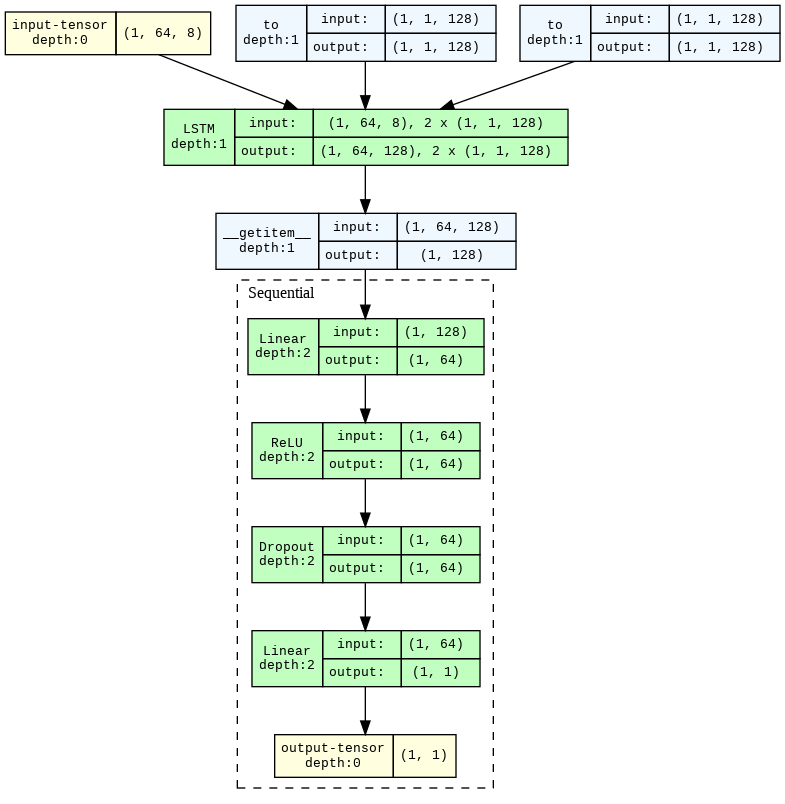

In [13]:
# Draw the model
model_graph = draw_graph(model, input_size=(1, 64, n_vars),
                         device=device,
                         expand_nested=True)
model_graph.visual_graph

Now we are ready to train. Recurrent models are very tricky in terms of their training, and the gradients usually present a very erratic behaviour. It is a good idea to clip the gradients, that is, to lower the value of the gradient so it does not explode. There is a Torch utility called clip_grad_norm, which allows to set a maximum value against the mean for the gradient.

We would generally advice to use a value of around 1 to 2 if you are seeing erratic training behaviour.

We will use the series-oriented RMSprop as our optimizer, and implemente norm clipping in the training loop.

In [14]:
# Set up optimizer and loss
learning_rate = 0.0001
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

We also need to create the data loaders. These are pretty simple: Just read from the pandas dataset and split them into train and test. We can do that easily with the following code.

In [15]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

def create_train_val_dataloaders(x_train_df, y_train, batch_size=64, val_size=0.33, seed=42):
    """
    Create DataLoader instances for training and validation datasets suited for LSTM models,
    ensuring stratified sampling for validation split.

    Parameters:
    x_train_df (pandas.DataFrame): DataFrame where each cell is a sequence (1D array or list) of length seq_len.
    y_train (numpy.ndarray or list): The labels for training.
    batch_size (int): The batch size for both train and validation loaders.
    val_size (float): The fraction of the data to be used for validation.

    Returns:
    train_loader (DataLoader): DataLoader for the training set.
    val_loader (DataLoader): DataLoader for the validation set.
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Convert the DataFrame of sequences into a correctly shaped 3D numpy array
    sequences = np.stack(x_train_df.apply(lambda s: np.stack(s.values).reshape(s.values[0].shape[0], -1), axis=1).values)

    # Ensure y_train is a numpy array
    y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train

    # Convert to 2D array if necessary
    if y_train.ndim == 1:
        y_train = y_train[:, None]

    # Perform stratified split
    train_idx, val_idx = train_test_split(
        np.arange(len(y_train)),  # Index-based split
        test_size=val_size,
        stratify=y_train,  # Ensures class proportions are maintained
        random_state=seed
    )

    # Subset the data based on stratified indices
    x_train_tensor = torch.from_numpy(sequences[train_idx]).float()
    y_train_tensor = torch.from_numpy(y_train[train_idx]).float()
    x_val_tensor = torch.from_numpy(sequences[val_idx]).float()
    y_val_tensor = torch.from_numpy(y_train[val_idx]).float()

    # Create TensorDatasets
    train_data = TensorDataset(x_train_tensor, y_train_tensor)
    val_data = TensorDataset(x_val_tensor, y_val_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [16]:
# Create the data loaders
batch_size = 2028
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

# Softmax function for the output
softmax_func = np.vectorize(lambda x: 1/(1+np.exp(-1 * x)))

Now we are finally ready to train.

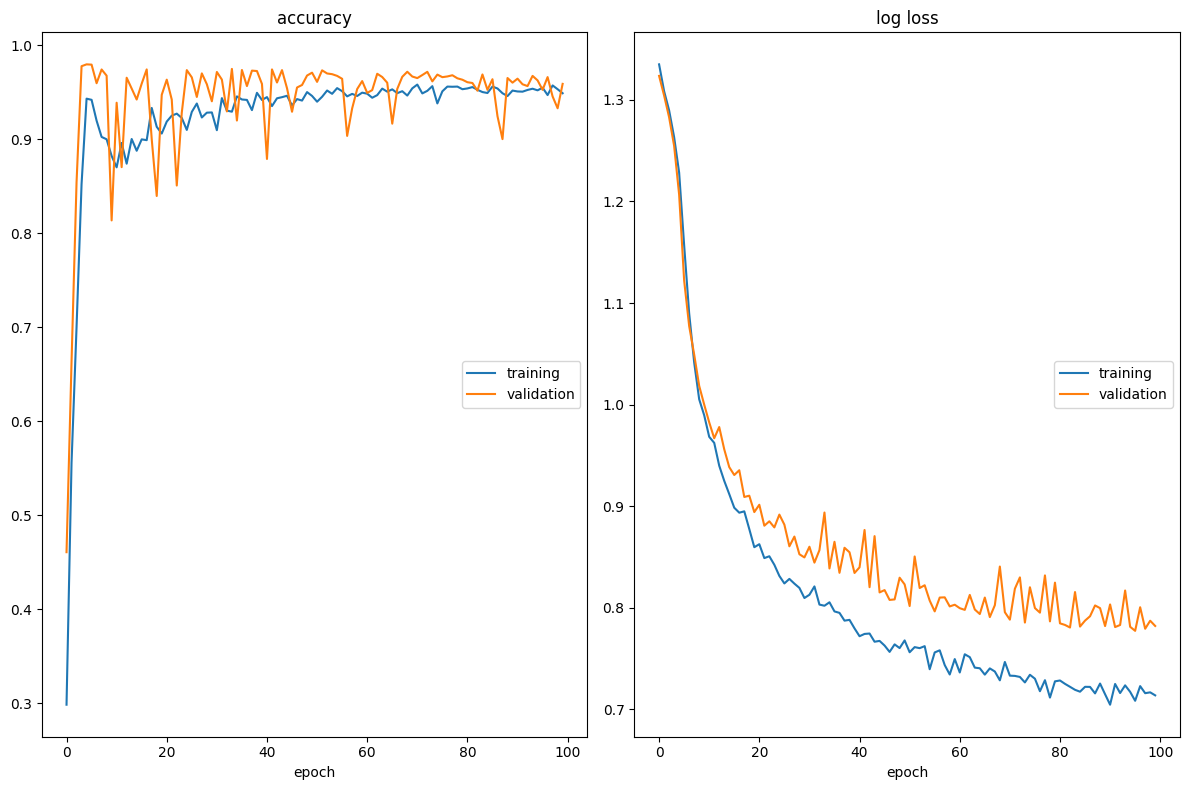

accuracy
	training         	 (min:    0.299, max:    0.958, cur:    0.949)
	validation       	 (min:    0.461, max:    0.980, cur:    0.959)
log loss
	training         	 (min:    0.705, max:    1.335, cur:    0.714)
	validation       	 (min:    0.777, max:    1.324, cur:    0.782)


In [17]:
SEED = 20
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Set run parameters
n_epochs = 100
liveloss = PlotLosses()

# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          model.train()
      else:
          model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          # print(labels)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()

              # Clip the gradient norm
              nn.utils.clip_grad_norm_(model.parameters(), 1)

              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_model.pth'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

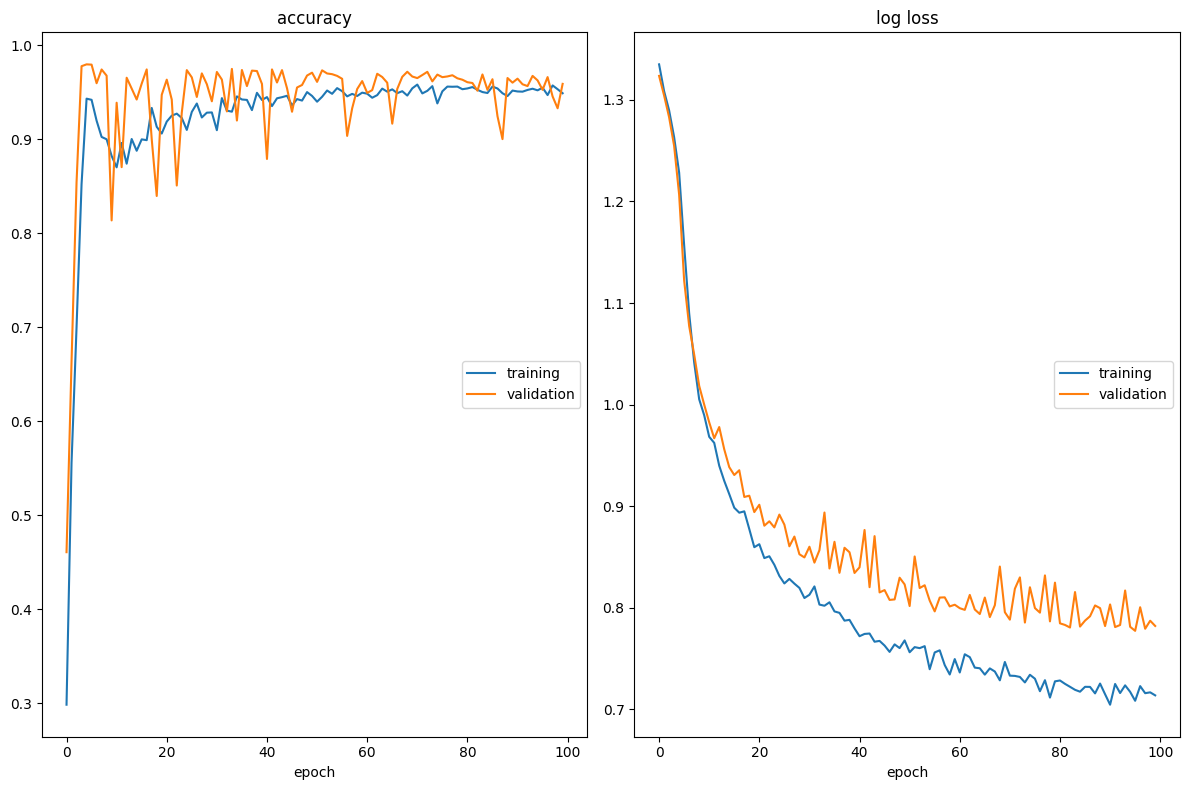

accuracy
	training         	 (min:    0.299, max:    0.958, cur:    0.949)
	validation       	 (min:    0.461, max:    0.980, cur:    0.959)
log loss
	training         	 (min:    0.705, max:    1.335, cur:    0.714)
	validation       	 (min:    0.777, max:    1.324, cur:    0.782)


<Figure size 640x480 with 0 Axes>

In [18]:
  # Plot the loss and save it.
  liveloss.send()
  plt.savefig('LSTM.pdf')

Training is progressing! Let's apply it to the test set and see what we get. You may also want to keep training, as the model is still learning after 100 epochs.

In [19]:
def create_test_dataloader(x_test_df, y_test=None, batch_size=64, seed=42):
    """
    Create DataLoader instance for the test dataset.

    Parameters:
    x_test_df (pandas.DataFrame): DataFrame where each cell is a sequence (1D array or list) of length seq_len.
    y_test (numpy.ndarray, optional): The labels for testing. Pass None if there are no labels.
    batch_size (int): The batch size for the test loader.

    Returns:
    test_loader (DataLoader): DataLoader for the test set.
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)

    # Convert the DataFrame of sequences into a correctly shaped 3D numpy array
    # sequences.shape should be (number of samples, seq_len, number of features per timestep)
    sequences = np.stack(x_test_df.apply(lambda s: np.stack(s.values).reshape(s.values[0].shape[0], -1), axis=1).values)

    # Convert to PyTorch tensors
    x_test_tensor = torch.from_numpy(sequences).float()

    # Create a TensorDataset from the input data
    if y_test is not None:
        # Check if y_test is a numpy array, if not convert it
        if not isinstance(y_test, np.ndarray):
            y_test = np.array(y_test)

        # Convert labels to a PyTorch tensor
        y_test_tensor = torch.from_numpy(y_test).float()

        # Assert that the number of samples matches
        assert len(x_test_tensor) == len(y_test_tensor), "The number of input samples and labels must be the same."
        test_data = TensorDataset(x_test_tensor, y_test_tensor)
    else:
        test_data = TensorDataset(x_test_tensor)

    # Create the DataLoader for the test set
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return test_loader

In [20]:
test_loader = create_test_dataloader(x_test, y_test.reshape(-1,1))

In [21]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [22]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

The test set accuracy is 95.72%
The test set loss is 0.785


The following code evaluates the model's performance by computing and visualizing the confusion matrix as a heatmap.

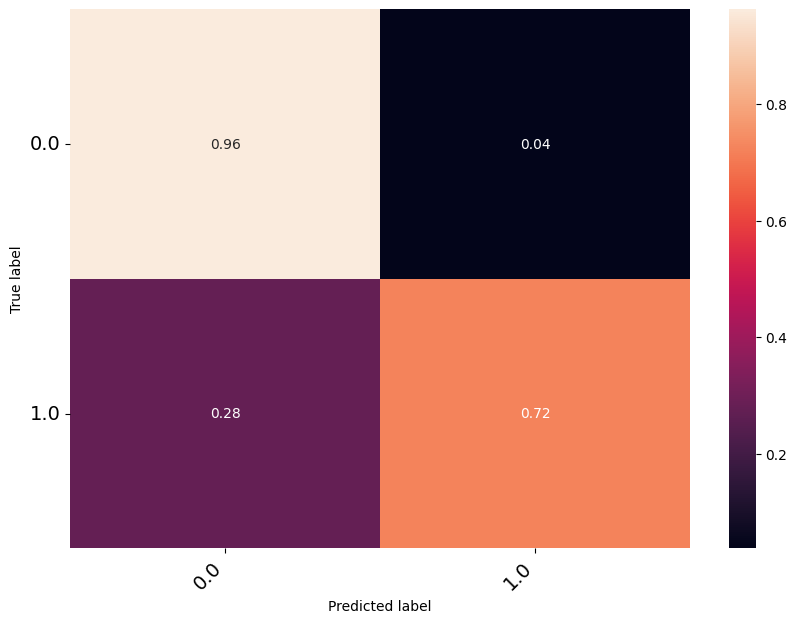

In [23]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.savefig('AUC_LSTM.pdf')
plt.show()

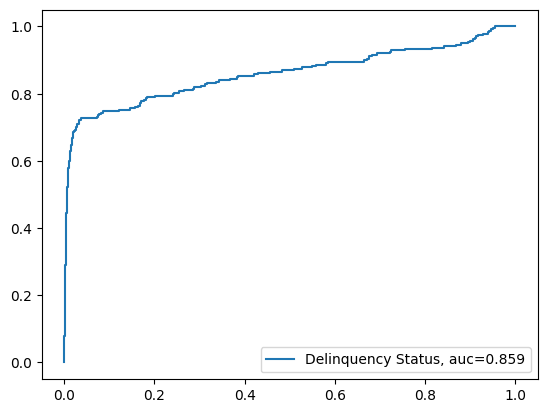

In [24]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Delinquency Status, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('ROC_LSTM.pdf')
plt.show()

Finally, we calculate and visualize the ROC (Receiver Operating Characteristic) curve to evaluate the performance of the model.

## LSTM with multiple layers
To improve training, we can try to chain LSTMs. This can help as you won't need to add just one very large (thus intractable) LSTM and instead can train two smaller ones. This is easily done in pytorch simply by setting the **`layer_dim`** parameter to a higher number. Let's try to stack two LSTMs and see the performance.

LSTMClassifier(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


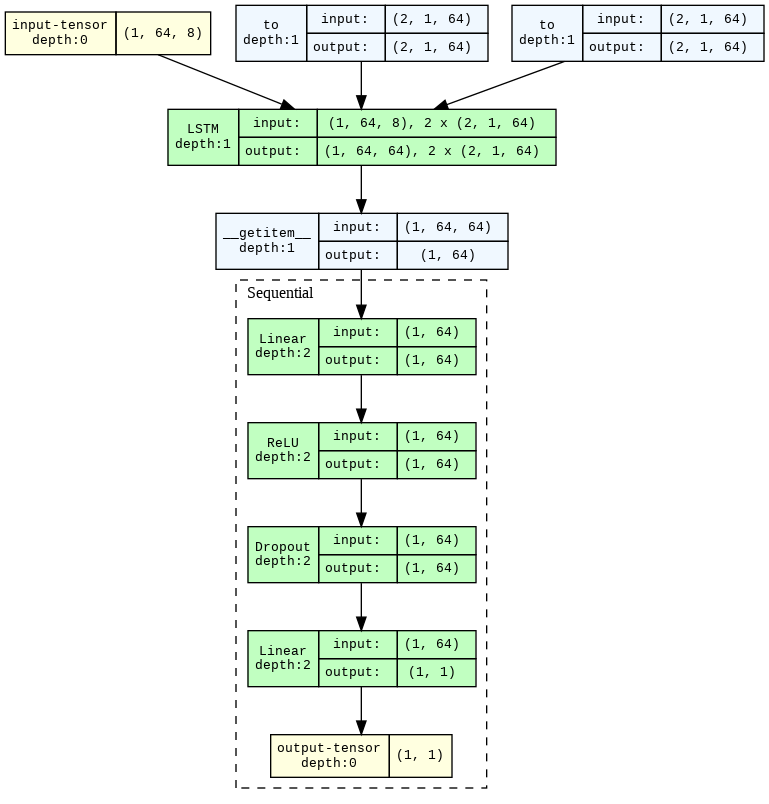

In [25]:
multi_lstm_model = LSTMClassifier(n_vars, 64, 2, 64, 1).to(device)
print(multi_lstm_model)

# Draw the model
model_graph = draw_graph(multi_lstm_model, input_size=(1, 64, n_vars),
                         device=device,
                         expand_nested=True)
model_graph.visual_graph

As we can see, this model now passes a much more reduced number of features to the LSTM layer, thus allowing for a reduced complexity. Of course, this will only be as good as the features are, so you'll need to experiment to get this right.

Let's train the model.

We will be very aggressive with the norm clipping now. You can identify the need for this if the losses are very unstable. Experiment with this value for your own applications! We'll also use Adam as our optimizer.

In [26]:
# Set up optimizer and loss
learning_rate = 0.0001
optimizer = optim.Adam(multi_lstm_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

In [27]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Create the data loaders
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

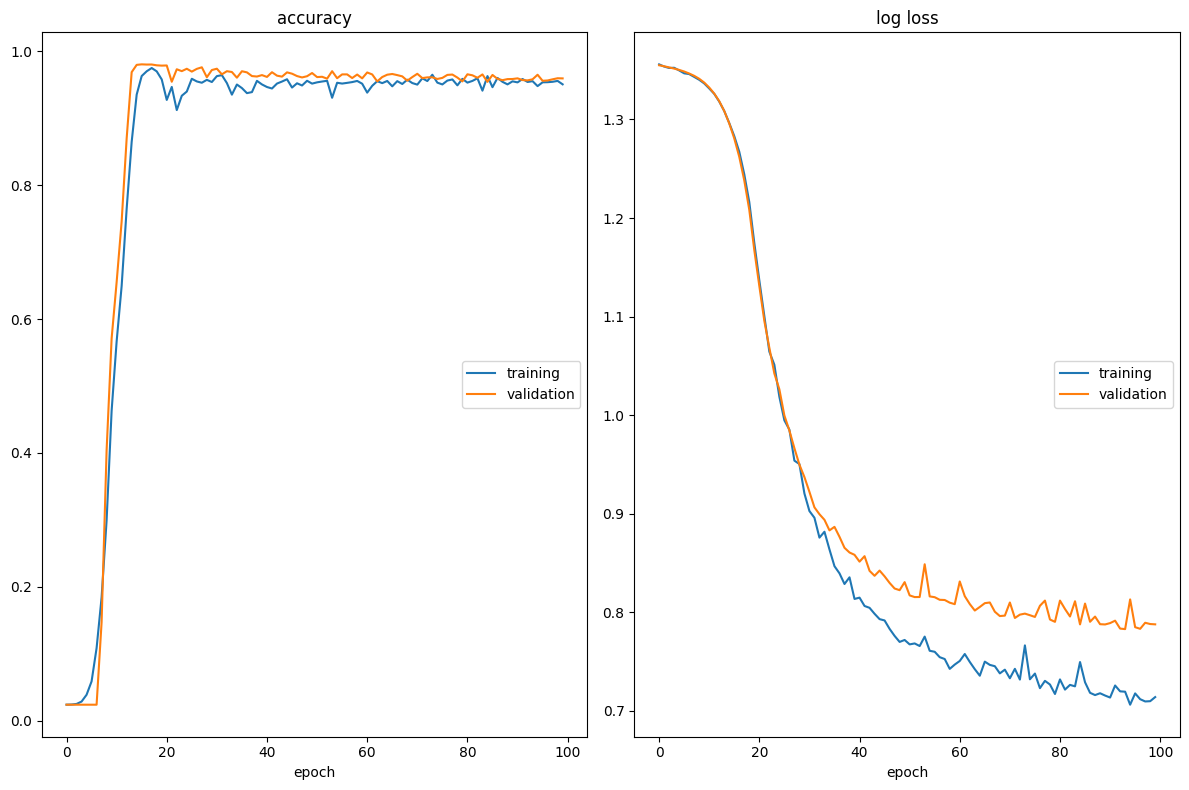

accuracy
	training         	 (min:    0.024, max:    0.975, cur:    0.951)
	validation       	 (min:    0.024, max:    0.980, cur:    0.959)
log loss
	training         	 (min:    0.706, max:    1.356, cur:    0.714)
	validation       	 (min:    0.783, max:    1.355, cur:    0.788)


In [28]:
SEED = 20
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Set run parameters
n_epochs = 100
liveloss = PlotLosses()


# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          multi_lstm_model.train()
      else:
          multi_lstm_model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = multi_lstm_model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              # Clip the gradient norm
              nn.utils.clip_grad_norm_(multi_lstm_model.parameters(), 0.1)
              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_multi_lstm_model.pth'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(multi_lstm_model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

The LSTM model now achieves a better loss. Keep in mind that this was done without any data cleaning—only standardization!

Notably, the optimizer took some time to find the right direction of descent, emphasizing the importance of patience during training.

It’s easy to introduce redundant layers or unnecessary time series features, which may impact performance. I encourage you to experiment with different architectures and continue training—it shouldn’t be too difficult to further improve the results.

Now, let’s evaluate the model on the test set. We begin by loading the best model.

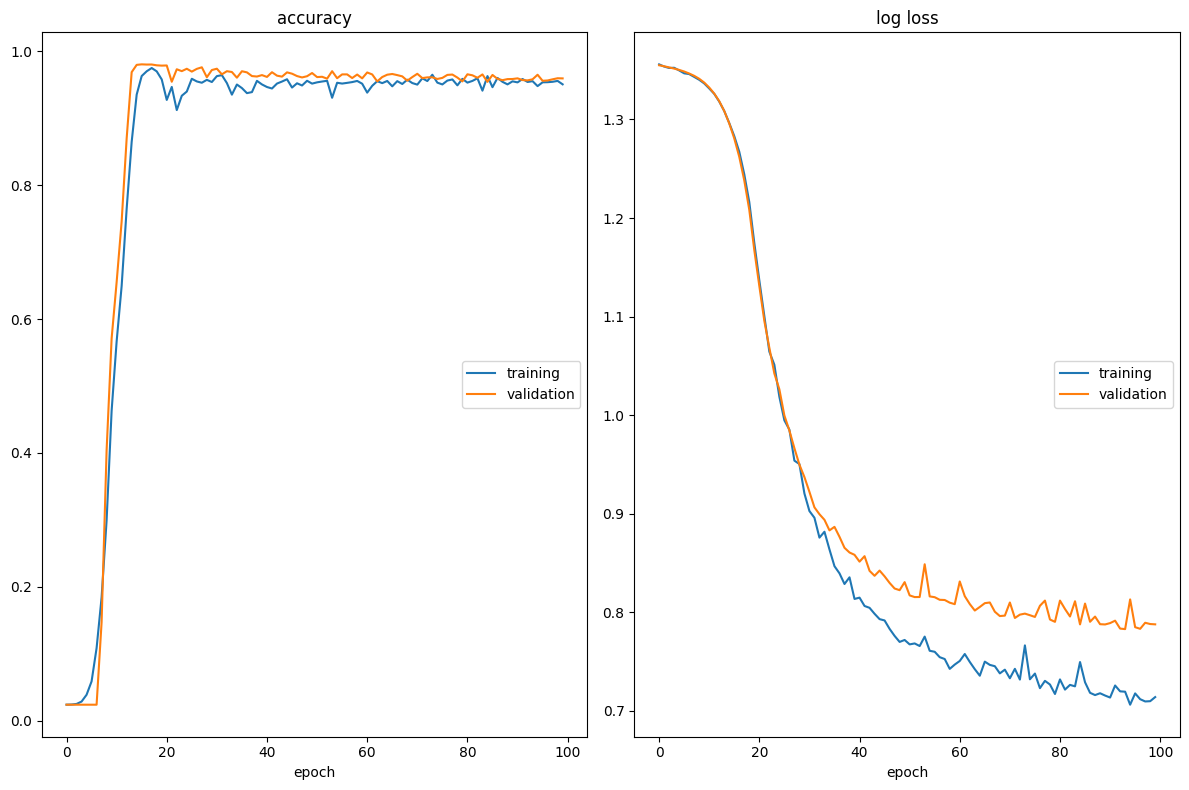

accuracy
	training         	 (min:    0.024, max:    0.975, cur:    0.951)
	validation       	 (min:    0.024, max:    0.980, cur:    0.959)
log loss
	training         	 (min:    0.706, max:    1.356, cur:    0.714)
	validation       	 (min:    0.783, max:    1.355, cur:    0.788)


<Figure size 640x480 with 0 Axes>

In [29]:
liveloss.send()
plt.savefig('MultiLSTM_Training.pdf')

In [30]:
multi_lstm_model.load_state_dict(torch.load('best_multi_lstm_model.pth'))

<All keys matched successfully>

In [31]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    multi_lstm_model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = multi_lstm_model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

The test set accuracy is 96.11%
The test set loss is 0.771


We have 71.61% of test accuracy. The ROC curve will give us a better view of what is happening.

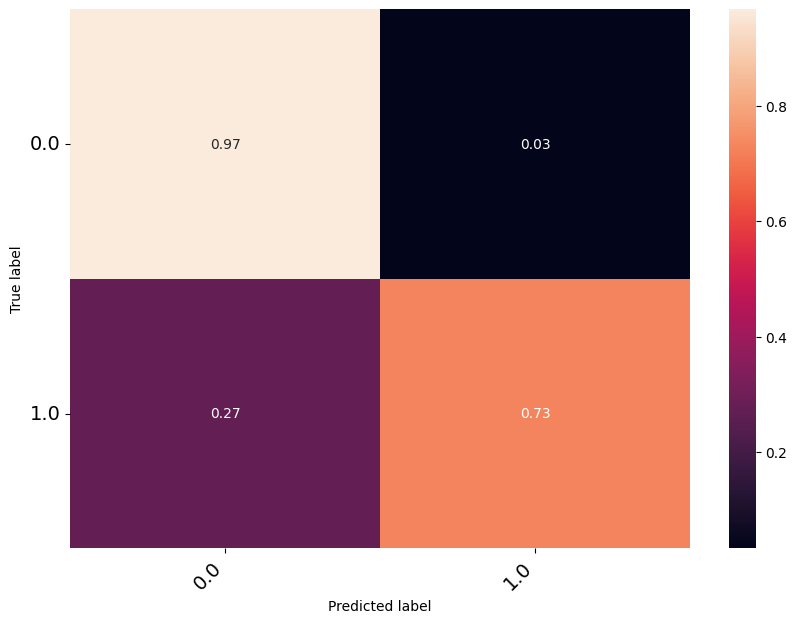

In [32]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.savefig('AUC_MultiLSTM.pdf')
plt.show()

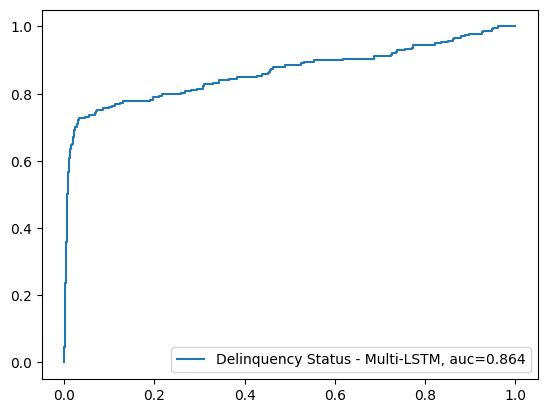

In [33]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Delinquency Status - Multi-LSTM, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('ROC_MultiLSTM.pdf')
plt.show()

We achieve a slightly better AUC! This was all done with very little processing. We are able to successfully combine eight different time series into a unique model.

## GRU
Now we will train a GRU. In theory, a GRU will be able to reach the same results as the LSTM but using less parameters.

GRUs are more efficient, so you can either use the same size that will run faster, or increase the size to try to learn more. Let's do the former.

In [34]:
# Define the GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, classifier_dim, output_dim):
        super(GRUClassifier, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your GRU
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            #nn.Softmax(dim=1) # No need for softmax with logit loss.
       )

    # Forward method
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Forward pass
        out, hn = self.gru(x, h0)
        out = self.classifier(out[:, -1, :])
        return out

In [35]:
# Initialize the model
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

n_vars = x_train.shape[1]
gru_model = GRUClassifier(n_vars, 64, 2, 64, 1).to(device)
print(gru_model)

GRUClassifier(
  (gru): GRU(8, 64, num_layers=2, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Perfect! Let's train the model now. The process is the same as before.

In [36]:
# Set up optimizer and loss
learning_rate = 0.0001
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

In [37]:
# Create the data loaders
train_loader, val_loader = create_train_val_dataloaders(x_train, y_train.reshape(-1,1),
                                                       batch_size=batch_size)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

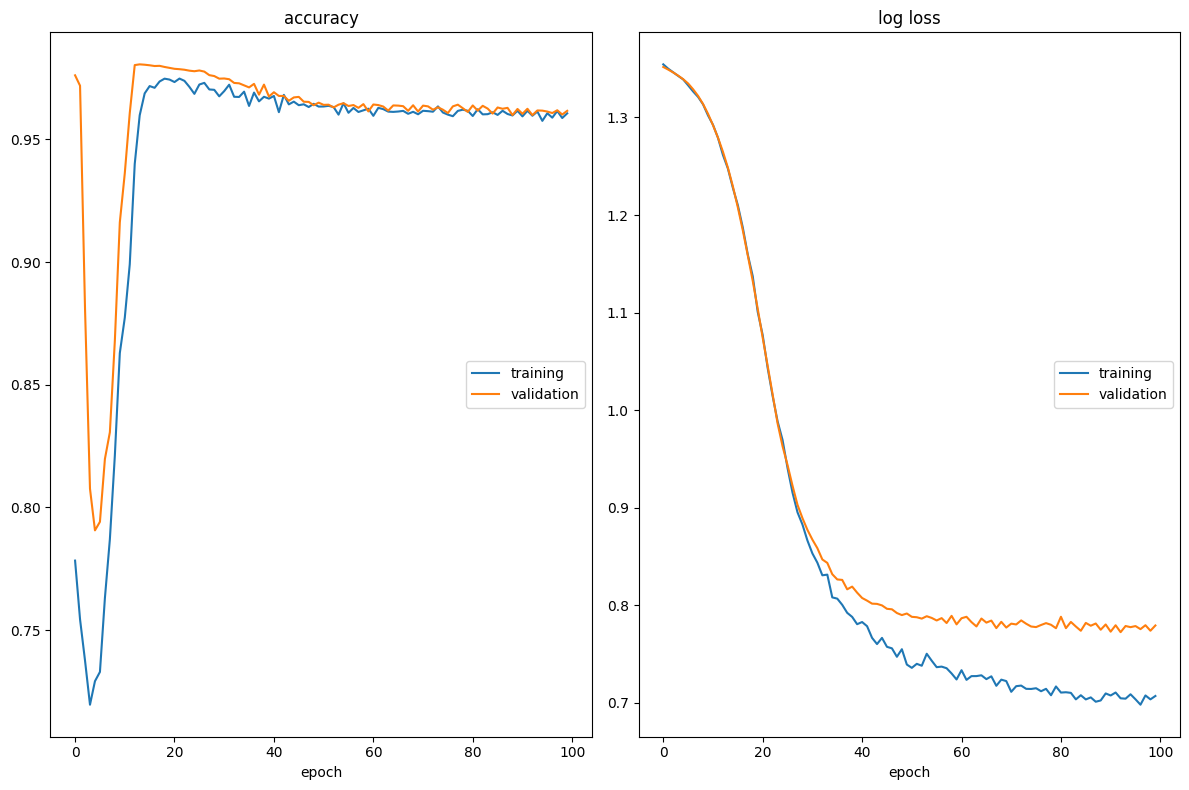

accuracy
	training         	 (min:    0.720, max:    0.975, cur:    0.961)
	validation       	 (min:    0.791, max:    0.981, cur:    0.962)
log loss
	training         	 (min:    0.698, max:    1.354, cur:    0.707)
	validation       	 (min:    0.772, max:    1.352, cur:    0.779)


In [38]:
SEED = 20
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Set run parameters
n_epochs = 100
liveloss = PlotLosses()

# Train!
for epoch in range(n_epochs):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          gru_model.train()
      else:
          gru_model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = gru_model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              # Clip the gradient norm
              nn.utils.clip_grad_norm_(gru_model.parameters(), 0.1)
              # Backpropagate
              optimizer.step()

          preds = softmax_func(outputs.detach().cpu().numpy())
          preds = np.round(preds)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'best_gru_model.pth'
              print(f'New best model found. Saving it as {model_path}')
              torch.save(gru_model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

In [39]:
gru_model.load_state_dict(torch.load('best_gru_model.pth'))

<All keys matched successfully>

In [40]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    gru_model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = gru_model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        preds = softmax_func(outputs.cpu().numpy())
        preds = np.round(preds)
        test_predictions = np.append(test_predictions, preds)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

The test set accuracy is 96.23%
The test set loss is 0.749


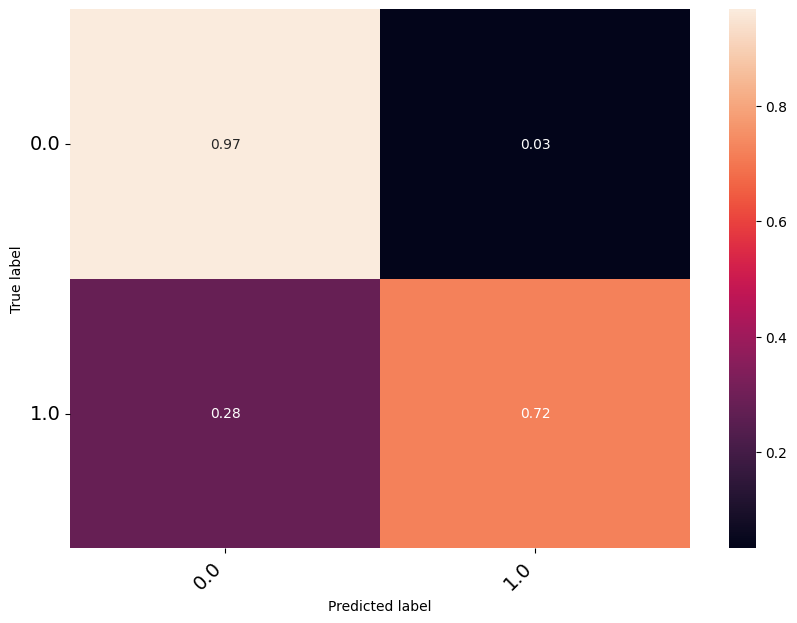

In [41]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.savefig('AUC_GRU.pdf')
plt.show()

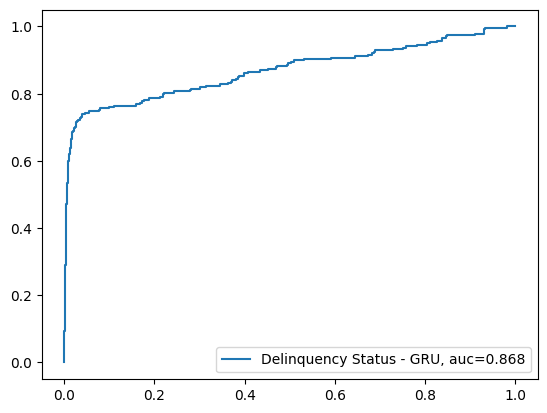

In [42]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Delinquency Status - GRU, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('ROC_GRU.pdf')
plt.show()

We got an even better model! Try to see if you can reach better ones! Let's load the optimal parameters and measure performance.

Can you do better? Experiment with the parameters.

## Combining static variables: A hybrid GRU.

In many cases, time series data includes static variables that remain constant over time. For example, in a loan dataset, static features such as credit score, property type, and occupancy status can provide valuable insights.

In this section, we will integrate these static variables into a GRU model and evaluate whether they improve performance.

First, we load and scale the original dataset, which contains information recorded at the time of loan application.

In [43]:
# Load filtered static dataset
static_df = pd.read_csv("TIme_Series_Lab_Origin_sampled.csv")

# Identify numeric and categorical columns
numeric_cols = ["CREDIT_SCORE", "CLTV", "DTI_RATIO", "ORIGINAL_UPB", "ORIGINAL_LOAN_TERM"]  # Excluding "NUMBER_OF_BORROWERS"
categorical_cols = ["FIRST_TIME_HOMEBUYER", "OCCUPANCY_STATUS", "PROPERTY_TYPE"]

In [44]:
# Add LOAN_NUMBER back before merging
x_df["LOAN_NUMBER"] = x_df.index  # Assign index (loan numbers) back to x_df

# Assign LOAN_NUMBER to train and test sets
loan_numbers_train = x_df.loc[x_df["if_test"] == 0, "LOAN_NUMBER"]
loan_numbers_test = x_df.loc[x_df["if_test"] == 1, "LOAN_NUMBER"]

# Split static data into train and test based on LOAN_NUMBER
static_train = static_df[static_df["LOAN_NUMBER"].isin(loan_numbers_train)]
static_test = static_df[static_df["LOAN_NUMBER"].isin(loan_numbers_test)]

# --- SCALE NUMERIC FEATURES ---
scaler = StandardScaler()
static_train[numeric_cols] = scaler.fit_transform(static_train[numeric_cols])  # Fit on train
static_test[numeric_cols] = scaler.transform(static_test[numeric_cols])  # Apply to test

# --- ONE-HOT ENCODE CATEGORICAL FEATURES ---
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_train = encoder.fit_transform(static_train[categorical_cols])  # Fit on train
encoded_test = encoder.transform(static_test[categorical_cols])  # Apply to test

# Convert to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=static_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=static_test.index)

<ipython-input-44-3883913049>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_train[numeric_cols] = scaler.fit_transform(static_train[numeric_cols])  # Fit on train
<ipython-input-44-3883913049>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_test[numeric_cols] = scaler.transform(static_test[numeric_cols])  # Apply to test


In [45]:
# Preserve LOAN_NUMBER and NUMBER_OF_BORROWERS (without scaling)
static_train_final = pd.concat([
    static_train[["LOAN_NUMBER", "NUMBER_OF_BORROWERS"]],  # Keep unscaled
    static_train[numeric_cols],  # Already scaled numeric features
    encoded_train_df  # One-hot encoded categorical features
], axis=1)

static_test_final = pd.concat([
    static_test[["LOAN_NUMBER", "NUMBER_OF_BORROWERS"]],  # Keep unscaled
    static_test[numeric_cols],  # Already scaled numeric features
    encoded_test_df  # One-hot encoded categorical features
], axis=1)

print(f"Processed Train Static Data Shape: {static_train_final.shape}")
print(f"Processed Test Static Data Shape: {static_test_final.shape}")

Processed Train Static Data Shape: (40000, 17)
Processed Test Static Data Shape: (10000, 17)


In [46]:
# Convert index to DataFrame to allow merging
x_train = x_train.copy()
x_test = x_test.copy()

# Add LOAN_NUMBER column before merging
x_train["LOAN_NUMBER"] = loan_numbers_train.values
x_test["LOAN_NUMBER"] = loan_numbers_test.values

# Merge static data with LSTM sequences
x_train = x_train.merge(static_train_final, on="LOAN_NUMBER", how="left")
x_test = x_test.merge(static_test_final, on="LOAN_NUMBER", how="left")

# Drop LOAN_NUMBER after merging
x_train.drop(columns=["LOAN_NUMBER"], inplace=True)
x_test.drop(columns=["LOAN_NUMBER"], inplace=True)

print(f"x_train Shape After Merge: {x_train.shape}")
print(f"x_test Shape After Merge: {x_test.shape}")

x_train Shape After Merge: (40000, 24)
x_test Shape After Merge: (10000, 24)


Next, we merge the static dataset with the time series dataset to incorporate time-invariant features into our analysis.

There are several ways to integrate static variables into a time series model. One approach is to concatenate static features with the model’s output before the final layer. Another option is to inject static features at every timestep in the model input. However, the latter requires expanding static features to match the time series length, which increases memory usage.

In this implementation, we will use the concatenation approach.

In [47]:
# Define the Hybrid GRU model
class HybridGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, static_dim, classifier_dim, output_dim):
        super(HybridGRU, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # GRU for time-series features
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer for static features
        self.fc_static = nn.Linear(static_dim, hidden_dim)

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, classifier_dim),  # Double hidden_dim due to concatenation
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_dim, output_dim),
            # nn.Softmax(dim=1) # No need for softmax with logit loss.
        )

    # Forward method
    def forward(self, x_seq, x_static):
        # Initialize hidden state
        h0 = torch.zeros(self.layer_dim, x_seq.size(0), self.hidden_dim).to(x_seq.device)

        # Forward pass through GRU
        out, hn = self.gru(x_seq, h0)
        gru_features = out[:, -1, :]  # Extract the last hidden state

        # Forward pass for static features
        static_features = self.fc_static(x_static)

        # Concatenate GRU output and static features
        combined_features = torch.cat((gru_features, static_features), dim=1)

        # Final classification layer
        output = self.classifier(combined_features)
        return output


In [48]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

time_series_indices = list(range(0, 8))  # First 8 columns are time-series
static_indices = list(range(8, x_train.shape[1]))  # Remaining columns are static features


# Model Parameters
input_size = len(time_series_indices)  # Features per timestep
hidden_size = 64  # hidden units
num_layers = 2  # GRU layers
static_size = len(static_indices)  # Static feature size
classifier_dim = 128
output_size = 1  # Binary classification (0/1)

# Initialize the model
hybrid_model = HybridGRU(input_size, hidden_size, num_layers, static_size, classifier_dim, output_size).to(device)
print(model)

LSTMClassifier(
  (lstm): LSTM(8, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [49]:
# Set up optimizer and loss
learning_rate = 0.0001
optimizer = optim.Adam(hybrid_model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

# Set global run parameters
best_vloss = 10000000

We also need to modify our train_val_dataloader function accordingly.

In [50]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

def create_train_val_dataloaders_with_static(
    x_train_df, y_train, time_series_indices, static_indices, batch_size=64, val_size=0.33, seed=42
):
    """
    Create DataLoader instances for training and validation datasets suited for Hybrid LSTM/GRU models,
    ensuring stratified sampling for validation split.

    Parameters:
    x_train_df (pandas.DataFrame): DataFrame containing both time-series and static features.
    y_train (numpy.ndarray or list): Labels for training, shape (num_samples, 1).
    time_series_indices (list): List of column indices for time-series features.
    static_indices (list): List of column indices for static features.
    batch_size (int): The batch size for both train and validation loaders.
    val_size (float): The fraction of the data to be used for validation.

    Returns:
    train_loader (DataLoader): DataLoader for the training set.
    val_loader (DataLoader): DataLoader for the validation set.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Extract and correctly reshape time-series data
    x_seq_train = np.stack([
        np.column_stack(row) for row in x_train_df.iloc[:, time_series_indices].values
    ])

    # Extract static features separately
    x_static_train = x_train_df.iloc[:, static_indices].values

    # Ensure y_train is a numpy array
    y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train

    # Convert to 2D array if necessary
    if y_train.ndim == 1:
        y_train = y_train[:, None]

    # Perform stratified split
    train_idx, val_idx = train_test_split(
        np.arange(len(y_train)),  # Index-based split
        test_size=val_size,
        stratify=y_train,  # Ensures class proportions are maintained
        random_state=seed
    )

    # Convert data to PyTorch tensors
    x_seq_tensor = torch.tensor(x_seq_train, dtype=torch.float32)
    x_static_tensor = torch.tensor(x_static_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Use stratified indices for train and validation sets
    x_seq_train_tensor, x_seq_val_tensor = x_seq_tensor[train_idx], x_seq_tensor[val_idx]
    x_static_train_tensor, x_static_val_tensor = x_static_tensor[train_idx], x_static_tensor[val_idx]
    y_train_tensor, y_val_tensor = y_tensor[train_idx], y_tensor[val_idx]

    # Validate shape before training
    print(f"x_seq_train_tensor shape: {x_seq_train_tensor.shape}")  # (train_samples, seq_len, num_features)
    print(f"x_static_train_tensor shape: {x_static_train_tensor.shape}")  # (train_samples, num_static_features)
    print(f"y_train_tensor shape: {y_train_tensor.shape}")  # (train_samples, 1)

    # Create TensorDatasets with two inputs
    train_data = TensorDataset(x_seq_train_tensor, x_static_train_tensor, y_train_tensor)
    val_data = TensorDataset(x_seq_val_tensor, x_static_val_tensor, y_val_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [51]:
# Create the data loaders
batch_size = 2028


# Create train and validation DataLoaders
train_loader, val_loader = create_train_val_dataloaders_with_static(
    x_train, y_train, time_series_indices, static_indices, batch_size=batch_size
)


dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

# Softmax function for the output
softmax_func = np.vectorize(lambda x: 1/(1+np.exp(-1 * x)))

x_seq_train_tensor shape: torch.Size([26800, 29, 8])
x_static_train_tensor shape: torch.Size([26800, 16])
y_train_tensor shape: torch.Size([26800, 1])


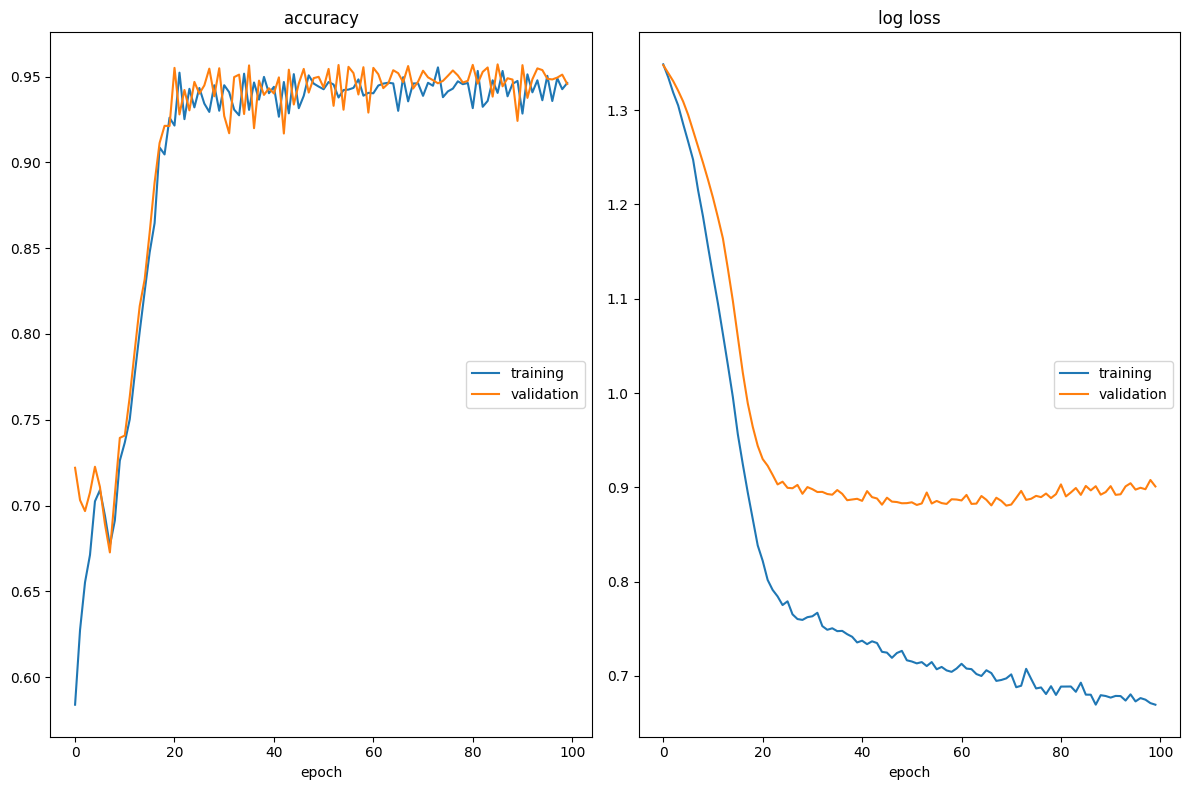

accuracy
	training         	 (min:    0.584, max:    0.955, cur:    0.946)
	validation       	 (min:    0.673, max:    0.957, cur:    0.946)
log loss
	training         	 (min:    0.670, max:    1.348, cur:    0.670)
	validation       	 (min:    0.881, max:    1.348, cur:    0.901)


In [52]:
SEED = 20
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)


# Initialize `livelossplot`
liveloss = PlotLosses()

# Run Parameters
n_epochs = 100
best_vloss = float('inf')

# Training Loop
for epoch in range(n_epochs):
    logs = {}

    for phase in ["train", "validation"]:
        if phase == "train":
            hybrid_model.train()
        else:
            hybrid_model.eval()

        running_loss = 0.0
        running_corrects = 0

        for i, (inputs_seq, inputs_static, labels) in enumerate(dataloaders[phase]):
            inputs_seq, inputs_static, labels = (
                inputs_seq.to(device),
                inputs_static.to(device),
                labels.to(device),
            )

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = hybrid_model(inputs_seq, inputs_static)
                loss = loss_fn(outputs, labels)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()

                    # Gradient Clipping to avoid exploding gradients
                    nn.utils.clip_grad_norm_(hybrid_model.parameters(), 0.1)
                    optimizer.step()

            # Convert outputs to probabilities
            preds = softmax_func(outputs.detach().cpu().numpy())
            preds = np.round(preds)  # Convert to binary classification (0 or 1)

            # Track metrics
            running_loss += loss.item() * inputs_seq.size(0)
            running_corrects += np.sum(preds.flatten() == labels.data.flatten().cpu().numpy())

            # Print batch loss every 10 steps
            if i % 10 == 9:
                batch_loss = running_loss / (10 * (i + 1))
                print(f"{phase} batch {i+1} loss: {batch_loss:.3f}")

            # Clear GPU memory
            torch.cuda.empty_cache()

        # Compute epoch loss and accuracy
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects / len(dataloaders[phase].dataset)

        prefix = ""
        if phase == "validation":
            prefix = "val_"

            # Track best validation loss, save the best model
            if epoch_loss < best_vloss:
                best_vloss = epoch_loss
                model_path = "best_hybrid_model.pth"
                print(f"New best model found. Saving it as {model_path}")
                torch.save(hybrid_model.state_dict(), model_path)

        logs[prefix + "log loss"] = epoch_loss
        logs[prefix + "accuracy"] = epoch_acc

    # Update live loss plot
    liveloss.update(logs)
    liveloss.send()


Again, we need to modify our test_dataloader function.

In [53]:
def create_test_dataloader_with_static(x_test_df, time_series_indices, static_indices, y_test=None, batch_size=64, seed=42):
    """
    Create DataLoader instance for the test dataset, processing both time-series and static features.

    Parameters:
    x_test_df (pandas.DataFrame): DataFrame containing both time-series and static features.
    time_series_indices (list): List of column indices for time-series features.
    static_indices (list): List of column indices for static features.
    y_test (numpy.ndarray, optional): Labels for testing. Pass None if there are no labels.
    batch_size (int): The batch size for the test loader.
    seed (int): Random seed for reproducibility.

    Returns:
    test_loader (DataLoader): DataLoader for the test set.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # Extract and correctly reshape time-series data
    x_seq_test = np.stack([
        np.column_stack(row) for row in x_test_df.iloc[:, time_series_indices].values
    ])

    # Extract static features separately
    x_static_test = x_test_df.iloc[:, static_indices].values

    # Convert to PyTorch tensors
    x_seq_tensor = torch.tensor(x_seq_test, dtype=torch.float32)  # (num_samples, seq_len, num_features)
    x_static_tensor = torch.tensor(x_static_test, dtype=torch.float32)  # (num_samples, num_static_features)

    # Validate shape before using
    print(f"x_seq_tensor shape: {x_seq_tensor.shape}")  # Expected: (num_samples, seq_len, num_features)
    print(f"x_static_tensor shape: {x_static_tensor.shape}")  # Expected: (num_samples, num_static_features)

    # If labels are provided, process them
    if y_test is not None:
        if not isinstance(y_test, np.ndarray):
            y_test = np.array(y_test)

        # Convert labels to PyTorch tensor
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure (num_samples, 1)

        # Ensure matching number of samples
        assert len(x_seq_tensor) == len(y_test_tensor), "Number of input samples and labels must match."
        test_data = TensorDataset(x_seq_tensor, x_static_tensor, y_test_tensor)
    else:
        test_data = TensorDataset(x_seq_tensor, x_static_tensor)

    # Create DataLoader
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return test_loader


In [54]:
test_loader = create_test_dataloader_with_static(x_test, time_series_indices, static_indices, y_test=y_test)

x_seq_tensor shape: torch.Size([10000, 29, 8])
x_static_tensor shape: torch.Size([10000, 16])


In [55]:
hybrid_model.load_state_dict(torch.load('best_hybrid_model.pth'))

<All keys matched successfully>

In [56]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    hybrid_model.eval()

    # Initialize loss and accuracy tracking
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, (inputs_seq, inputs_static, labels) in enumerate(test_loader):
        test_labels = np.append(test_labels, labels.cpu().numpy())

        # Move data to the appropriate device
        inputs_seq, inputs_static, labels = (
            inputs_seq.to(device),
            inputs_static.to(device),
            labels.to(device),
        )

        # Forward pass
        outputs = hybrid_model(inputs_seq, inputs_static)
        loss = loss_fn(outputs, labels)

        # Convert outputs to probabilities using sigmoid (since we use BCEWithLogitsLoss)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = np.round(probs)  # Convert to binary classification (0 or 1)

        # Store predictions
        test_probs = np.append(test_probs, probs)
        test_predictions = np.append(test_predictions, preds)

        # Track loss and accuracy
        running_loss += loss.item() * inputs_seq.size(0)
        running_corrects += np.sum(preds == labels.cpu().numpy().flatten())

    # Compute final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects / len(test_loader.dataset)

# Print test results
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss:.3f}')


Test Accuracy: 95.02%
Test Loss: 0.737


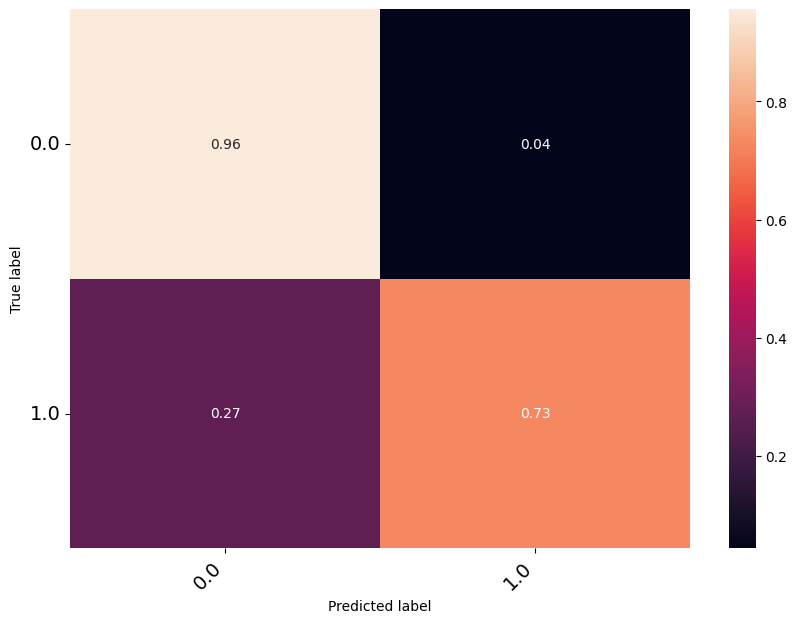

In [57]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=np.unique(test_labels),
        columns=np.unique(test_labels),
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.savefig('AUC_HybridGRU.pdf')
plt.show()

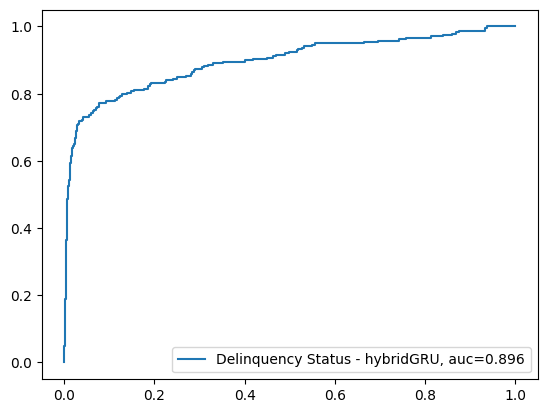

In [58]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_labels,
                             y_score = test_probs),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Delinquency Status - hybridGRU, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('ROC_HybridGRU.pdf')
plt.show()

We observe an increase in AUC, indicating some improvement. More importantly, this improvement happens around the mid-part of the ROC curve, hinting it happens where prediction is harder. We can see how the hybrid model squeezes as much learning as possible from the data, by leveraging multiple data sources.